# Deep Dive into Neural Network Architectures

In this lecture, we'll explore different types of neural networks that have revolutionized various fields, including image recognition, natural language processing, and generative modeling. We'll cover Convolutional Neural Networks (CNNs), Recurrent Neural Networks (RNNs), and Long Short-Term Memory networks (LSTMs). Get ready for a hands-on workshop experience with PyTorch!

**Prerequisites:** Basic understanding of neural networks, activation functions, backpropagation, and training.


## Convolutional Neural Networks (CNNs)

We learned about multi-layer perceptrons in the previous lab. A classic application for neural networks is image recognition. Consider, for simplicity's sake, an image which is a matrix of pixels. In a color image, each pixel might be represented by 3 RGB values. In greyscale, we can use a single integer which indicates how dark a pixel is. We can even flatten a 3x3 matrix into a 9x1 vector.

![rgb_pixels](images/4x4x3-rgb-image.png)  ![greyscale_pixels](images/greyscale_flattening.png)

We could try to provide the vector of pixel values as input to a multi-layer perceptron and ask it to classify the image, but how well do you think it could perform?

Take these very, very crude smiley faces and an X as a first example:

![Smile Faces](images/smiles_x.jpg)

If we use white = 0 and black = 1 and flatten the 7x7 grid to a vector with length 49, we end up with something like this:
`[0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0]`

With many many more examples, we might be able to discern some patterns, but seemingly there's not much more in common among the smiles than there is with the X. Now also consider that some smiley faces might be tipped on their sides, like this `:)`, oriented differently, or moved within the 7x7 grid we have chosen. Naively flattening the grid into a vector of numbers probably won't yield the results we're hoping for.

Enter Convolutional Neural Networks. CNNs are designed for processing grid-like data, such as images. They excel at capturing spatial hierarchies and local patterns, making them ideal for tasks like image recognition, object detection, and image segmentation.

![Convolutional Neural Network](images/cnn_sequence.png)

### Key Components

*   **Convolutional Layers:** Convolutional layers are the fundamental building blocks of CNNs that perform feature extraction through:
    * Kernels/Filters: These are small matrices (typically 3×3, 5×5, or 7×7) that slide across the input image to compute element-wise multiplications followed by summation. Each kernel detects specific patterns - early layers detect simple features like edges and gradients, while deeper layers identify complex patterns like textures and objects.
    * Stride: Controls how many pixels the filter moves at each step. Larger strides reduce spatial dimensions more aggressively.
    * Padding: Adding extra pixels (usually zeros) around the input to control output dimensions. "Same" padding preserves spatial dimensions, while "valid" padding reduces them.
    * Channel Dimensionality: Each convolutional layer typically increases the number of channels (feature maps) while decreasing spatial dimensions, creating a hierarchical feature representation.

![Convolutional Kernel](images/convolved-feature.gif)

*   **Pooling Layers:** Pooling layers reduce computational complexity and provide spatial invariance through:
    * Max Pooling: Selects the maximum value from each patch, effectively preserving the strongest features while discarding weaker activations.
    * Average Pooling: Calculates the average value of each patch, which can retain more background information.
    * Global Pooling: Reduces each feature map to a single value, often used before fully connected layers to dramatically reduce parameters.
    * Benefits: Pooling makes the network more robust to small translations in the input, reduces overfitting by providing a form of regularization, and decreases computational burden.

![Max and Average Pooling](images/max_v_average_pooling.png)

*   **Activation Functions:**  Activation functions introduce non-linearity, enabling networks to learn complex relationships:
    * ReLU (Rectified Linear Unit): f(x) = max(0,x). The most common activation in CNNs due to its computational efficiency and effectiveness in addressing the vanishing gradient problem.
    * Leaky ReLU: Modifies ReLU to allow small negative values, preventing "dead neurons."
    * ELU (Exponential Linear Unit): Provides smoother gradients for negative inputs while maintaining ReLU benefits.
    * Sigmoid/Tanh: Historically used but less common in hidden layers of modern CNNs due to vanishing gradient issues; sigmoid is still used for binary classification outputs.

*   **Fully Connected Layers:** These layers serve as the "decision-making" component of CNNs:
    * Flattening: Before fully connected layers, the 3D feature maps must be flattened into a 1D vector.
    * Dense Connections: Each neuron connects to every neuron in the previous layer, enabling global reasoning about features across the entire image.
    * Classification Head: Typically includes one or more fully connected layers followed by a softmax activation (for multi-class classification) or sigmoid (for binary classification).
    * Parameter Efficiency: These layers often contain the majority of the network's parameters, making them computationally expensive and prone to overfitting without proper regularization.

### References:
Image source and also excellent explanation: [Saturn Cloud's Guide to CNNs](https://saturncloud.io/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way/).
[DataCamp video on CNNs ~5 minutes](https://campus.datacamp.com/courses/intermediate-deep-learning-with-pytorch/images-convolutional-neural-networks?ex=5)

### Practical Example: Image Classification with CNNs

Let's build a CNN to classify images from the CIFAR-10 dataset using PyTorch. The [CIFAR-10 dataset](https://www.kaggle.com/c/cifar-10/) is a subset of a much larger dataset, containing 60000 32x32 color images containing one of ten object classes: {airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck}


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# convert images to PyTorch tensors, standardize RGB channels to mean = 0.5 and std = 0.5
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset, containing 60k 32x32 color images
# create shuffled training batches of 64 images each
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


class CNN(nn.Module):
    # CNN architecture
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)         # first convolutional layer: 3 input channels (RGB), 6 output channels, 5x5 kernel/filter
        self.pool = nn.MaxPool2d(2, 2)          # 2x2 max pooling layers with stride 2 (cuts spatial dimensions in half)
        self.conv2 = nn.Conv2d(6, 16, 5)        # second convolutional layer: 6 input channels, 16 output channels, 5x5 kernel/filter
        self.fc1 = nn.Linear(16 * 5 * 5, 120)   # first fully connected layer, 16 output * 5 pixels * 5 pixels to 120 neurons
        self.fc2 = nn.Linear(120, 84)           # second fully connected layer, 120 neurons to 84 neurons
        self.fc3 = nn.Linear(84, 10)            # third fully connected layer, 84 neurons to 10 neurons

    # forward pass
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # first conv layer -> ReLU activation -> max pooling
        x = self.pool(torch.relu(self.conv2(x))) # second conv layer -> ReLU activation -> max pooling
        x = x.view(-1, 16 * 5 * 5)               # flattening 3D feature maps (16*5*5) into 1D vector
        x = torch.relu(self.fc1(x))              # three fully connected layers with ReLU between them
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x                                # output is 10 logits, one per class

# Initialize the model, optimizer, and loss function
model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters())      # Adam optimizer adapts learning rate for each parameter
criterion = nn.CrossEntropyLoss()               # CrossEntropyLoss combines softmax activation and negative log-likelihood loss

# Training loop (simplified for brevity)
for epoch in range(2):  # Adjust the number of epochs as needed
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device) # move tensors to GPU if possible
        optimizer.zero_grad()                   # zeros the gradients to prevent accumulation
        outputs = model(inputs)                 # forward pass to get predictions
        loss = criterion(outputs, labels)       # calculates loss between predictions and true class
        loss.backward()                         # back propagates to compute gradients
        optimizer.step()                        # updates weights using the optimizer
        if i % 100 == 0:
            print(f"Epoch: {epoch + 1}, Batch: {i}, Loss: {loss.item()}")       # prints loss every 100 batches to show changes

print('Finished Training')


Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, Batch: 0, Loss: 2.3116374015808105
Epoch: 1, Batch: 100, Loss: 1.8910170793533325
Epoch: 1, Batch: 200, Loss: 1.549450159072876
Epoch: 1, Batch: 300, Loss: 1.5100762844085693
Epoch: 1, Batch: 400, Loss: 1.5667197704315186
Epoch: 1, Batch: 500, Loss: 1.6899704933166504
Epoch: 1, Batch: 600, Loss: 1.4107072353363037
Epoch: 1, Batch: 700, Loss: 1.4023810625076294
Epoch: 2, Batch: 0, Loss: 1.3140592575073242
Epoch: 2, Batch: 100, Loss: 1.4411625862121582
Epoch: 2, Batch: 200, Loss: 1.3780819177627563
Epoch: 2, Batch: 300, Loss: 1.4918187856674194
Epoch: 2, Batch: 400, Loss: 1.3387620449066162
Epoch: 2, Batch: 500, Loss: 1.53343665599823
Epoch: 2, Batch: 600, Loss: 1.2907698154449463
Epoch: 2, Batch: 700, Loss: 1.3173434734344482
Finished Training


### How can we interpret this output?

#### Training Progression
The output shows loss values at different points during training:
* Format: Epoch: [epoch_number], Batch: [batch_number], Loss: [loss_value]
* Loss is printed every 100 batches (as specified in the code with if i % 100 == 0)

#### Key Observations:
1. Loss Trend: The loss starts at around 2.31 in the first epoch and generally decreases over time, ending at about 1.44 by the end of the second epoch.
2. Learning Progress:
    * Note: each time this is run, the batches will be randomized, resulting in different output.
    * First epoch: Loss decreases from 2.31 → ~1.31 (approximately 40% reduction)
    * Second epoch: Loss fluctuates but continues the downward trend from 1.44 → ~1.32
3. Fluctuations: Notice that the loss doesn't decrease monotonically. There are ups and downs (e.g., 1.44 → 1.37 → 1.49). This is normal in mini-batch training, as each batch contains different images with varying difficulty.
4. Training Speed: Each epoch processes about 700+ batches with the batch size of 64. Since CIFAR-10 has 50,000 training images, this aligns with approximately 45,000-50,000 images per epoch.

#### Interpretation:
* Model is Learning: The consistent downward trend in loss indicates your model is learning useful patterns from the data.
* Early Training Phase: With only 2 epochs, your model is still in the early learning phase. Modern CNN training typically involves 50-200 epochs for CIFAR-10.
* Room for Improvement: The final loss value of around 1.32 is still relatively high for a converged model on CIFAR-10. Well-tuned models can achieve loss values below 0.5.
* Learning Rate: The gradual decrease in loss suggests your learning rate is reasonable (not too high causing divergence, not too low causing stagnation).

### Think about what the next steps should be...

### Evaluating Your Model

You'll remember the Confusion Matrix from Data Analytics and Machine Learning. This can help us visualize the performance of a classification model.

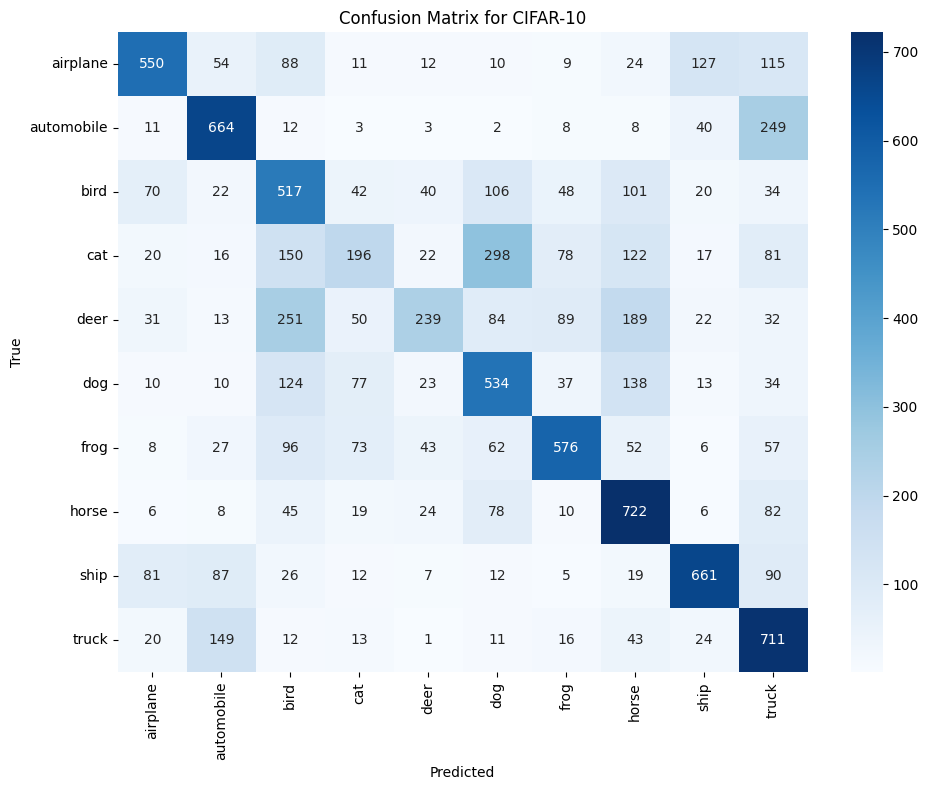

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Gather predictions and true labels
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in testloader:
        # Move input data to GPU
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Move predictions and labels back to CPU for numpy conversion
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot with labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CIFAR-10')
plt.tight_layout()
plt.show()

We can also look at a normalized confusion matrix.

#### What can you say about the CNN's performance? What does it do well? Where does it make mistakes?

## Recurrent Neural Networks (RNNs)

RNNs represent a powerful class of neural networks specifically designed to model sequential data by maintaining an internal memory. Unlike traditional feedforward neural networks, which process each input independently, RNNs incorporate feedback connections that allow information to persist across time steps. This unique architecture makes RNNs particularly well-suited for tasks involving sequential or temporal data, such as natural language processing, speech recognition, time series forecasting, and music generation.

### Key Components:

* Input layer: Receives the current data point in the sequence
* Hidden state: Acts as the network's "memory," updated at each time step
* Output layer: Produces predictions based on the current hidden state
* Recurrent connections: Allow information to flow between time steps

![RNN Architectures](images/rnn_statelayers.png)

### Types of RNNs
RNNs come in several configurations to address different sequence processing needs:

* One-to-One: Standard feedforward neural network (not truly recurrent)
* One-to-Many: Single input produces a sequence (e.g., image captioning)
* Many-to-One: Sequence input produces a single output (e.g., sentiment analysis)
* Many-to-Many: Sequence input produces sequence output (e.g., machine translation)
    * Synchronized: Output at each time step (e.g., POS tagging)
    * Encoder-Decoder: Full input sequence processed before generating outputs (e.g., translation)

### Training RNNs
RNNs are trained using Backpropagation Through Time (BPTT), an extension of the standard backpropagation algorithm that unfolds the recurrent network through time to compute gradients.

#### Challenges in Training
* Vanishing Gradients: One of the most significant challenges in training RNNs is the vanishing gradient problem. During backpropagation, gradients are multiplied by weight matrices repeatedly as they flow backward through time steps. If these values are small (< 1), the gradient diminishes exponentially, making it difficult for the network to learn long-term dependencies.
* Exploding Gradients: Conversely, if gradient values are large (> 1), they can grow exponentially during backpropagation, causing training instability. This is known as the exploding gradient problem and often results in numerical overflow or model divergence.

To address these challenges, practitioners employ several techniques:
* Gradient clipping: Limiting gradient magnitudes to prevent explosion
* Careful weight initialization: Using specialized initialization methods
* Advanced architectures: Employing LSTM or GRU cells (discussed below)
* Skip connections: Adding direct paths between distant time steps

### References:
Image source: [IBM Developer RNN Deep Dive](https://developer.ibm.com/learningpaths/supervised-deep-learning/recurrent-neural-networks/introduction-recurrent-neural-networks/)
[DataCamp Video on RNNs ~5 minnutes](https://campus.datacamp.com/courses/intermediate-deep-learning-with-pytorch/sequences-recurrent-neural-networks?ex=4)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the RNN model
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden=None):
        batch_size = x.size(0)
        
        # Initialize hidden state if not provided
        if hidden is None:
            hidden = self.init_hidden(batch_size)
        
        # Convert input to embeddings
        embedded = self.embedding(x)
        
        # Process through RNN
        output, hidden = self.rnn(embedded, hidden)
        
        # Reshape for fully connected layer
        output = output.reshape(-1, self.hidden_size)
        output = self.fc(output)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        # Create hidden states on the same device as the model
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device))

# Training function
def train(model, data, seq_length, batch_size, epochs, lr=0.001):
    model.to(device)  # Move model to GPU if available
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        hidden = None
        total_loss = 0
        
        # Create batches
        n_batches = len(data) // (seq_length * batch_size)
        data_tensor = torch.tensor(data[:n_batches * seq_length * batch_size]).long().to(device)
        data_tensor = data_tensor.view(batch_size, -1)
        
        for i in range(0, data_tensor.size(1) - seq_length, seq_length):
            # Get input and target sequences
            inputs = data_tensor[:, i:i+seq_length]
            targets = data_tensor[:, i+1:i+seq_length+1]
            
            # Forward pass
            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs, targets.reshape(-1))
            
            # Detach hidden state to prevent backpropagation through entire history
            hidden = (hidden[0].detach(), hidden[1].detach())
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5)  # Gradient clipping
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss/n_batches:.4f}")

# Generate text function
def generate_text(model, chars, char_to_idx, idx_to_char, seed_text, gen_length=200, temperature=0.8):
    model.eval()
    
    # Convert seed text to indices
    seed_idx = [char_to_idx[c] for c in seed_text]
    input_seq = torch.tensor([seed_idx]).long().to(device)
    
    hidden = None
    generated_text = seed_text
    
    # Generate new characters
    with torch.no_grad():  # Disable gradient calculation for inference
        for i in range(gen_length):
            output, hidden = model(input_seq, hidden)
            
            # Apply temperature to make sampling more/less conservative
            output = output / temperature
            
            # Sample from the predicted distribution
            probs = torch.softmax(output[-1], dim=0).cpu().numpy()
            next_char_idx = np.random.choice(len(chars), p=probs)
            
            # Add to generated text
            generated_text += idx_to_char[next_char_idx]
            
            # Update input sequence
            input_seq = torch.tensor([[next_char_idx]]).long().to(device)
    
    return generated_text

# Running it with your own text

f = open("data/fairy_tales.txt","r",encoding="utf-8")
text = f.read()

# Create character mappings
chars = sorted(list(set(text)))
char_to_idx = {c: i for i, c in enumerate(chars)}
idx_to_char = {i: c for i, c in enumerate(chars)}

# Convert text to indices
data = [char_to_idx[c] for c in text]

# Initialize model
model = CharRNN(
    input_size=len(chars),
    hidden_size=128,
    output_size=len(chars),
    n_layers=2
).to(device)

# Train model
train(model, data, seq_length=50, batch_size=32, epochs=5)

# Generate text
generated = generate_text(
    model, chars, char_to_idx, idx_to_char,
    seed_text="The", gen_length=500
)
print(generated)


Using device: cuda
Epoch 1, Loss: 3.3108
Epoch 2, Loss: 2.7594
Epoch 3, Loss: 2.4432
Epoch 4, Loss: 2.2770
Epoch 5, Loss: 2.1700
Epoch 6, Loss: 2.0860
Epoch 7, Loss: 2.0175
Epoch 8, Loss: 1.9596
Epoch 9, Loss: 1.9089
Epoch 10, Loss: 1.8642
Epoch 11, Loss: 1.8235
Epoch 12, Loss: 1.7876
Epoch 13, Loss: 1.7557
Epoch 14, Loss: 1.7266
Epoch 15, Loss: 1.7000
Epoch 16, Loss: 1.6757
Epoch 17, Loss: 1.6536
Epoch 18, Loss: 1.6332
Epoch 19, Loss: 1.6143
Epoch 20, Loss: 1.5966
Epoch 21, Loss: 1.5800
Epoch 22, Loss: 1.5641
Epoch 23, Loss: 1.5489
Epoch 24, Loss: 1.5342
Epoch 25, Loss: 1.5202
The Tash the morning now but of the kiss.
Bable down and and then the way have the bent cords dick.
The renars dess to my for the brand
Let me see toll naple, begres to me you the betters of blead 
Die an the feet and strees,
Then beck shounders my my door
To know the sponna mouth on the money that you hange-neakin' on the rain
And the ount over the suble
But give to streat, the sun ofpating on a stret,
And in h

### Try it out!

Start with few epochs to get an idea of the time training will require. Try it with different numbers of epochs for training and different input files. In the `data` folder, we've provided files with fairy tales, Shakespeare, and Bob Dylan. How do they compare?

## Long Short-Term Memory Networks (LSTMs)

LSTMs are a type of RNN designed to address the vanishing gradient problem and capture long-term dependencies in sequences. They achieve this through a more complex cell structure with gates that control the flow of information.

### Key Idea

LSTMs introduce memory cells and gates (input, forget, output) that regulate the flow of information into and out of the cell. This allows them to selectively remember or forget information, enabling them to learn long-term dependencies.  
[Image of an LSTM cell with gates]

### Practical Example: Time Series Prediction with LSTMs

Let's build an LSTM to predict future values in a time series using PyTorch.


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic time series data
data = np.sin(np.linspace(0, 20, 1000)) + 0.2 * np.random.randn(1000)

# Normalize data
data = (data - np.mean(data)) / np.std(data)

# Create sequences
seq_length = 50
X =
y =
for i in range(len(data) - seq_length - 1):
    X.append(data[i:i + seq_length])
    y.append(data[i + seq_length])
X = np.array(X)
y = np.array(y)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)  # Add a dimension for the feature
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[-1])  # Take the output from the last time step
        return out, hidden

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

# Hyperparameters
hidden_size = 64
learning_rate = 0.001
epochs = 100

# Initialize the model, optimizer, and loss function
model = LSTM(1, hidden_size, 1)  # Input size is 1 (single feature)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training loop (simplified for brevity)
for epoch in range(epochs):
    for i in range(len(X_train)):
        hidden = model.init_hidden()
        optimizer.zero_grad()
        outputs, hidden = model(X_train[i].unsqueeze(1), hidden)  # Add a dimension for the sequence
        loss = criterion(outputs, y_train[i])
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

print('Finished Training')

# Prediction and visualization (simplified for brevity)
with torch.no_grad():
    predictions =
    hidden = model.init_hidden()
    for i in range(len(X_test)):
        output, hidden = model(X_test[i].unsqueeze(1), hidden)
        predictions.append(output.item())

plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


## Generative Adversarial Networks (GANs)

GANs consist of two neural networks, a generator and a discriminator, that compete against each other in a unique training process. The generator tries to create realistic data samples, while the discriminator tries to distinguish between real and generated samples. This adversarial process pushes both networks to improve, leading to the generation of highly realistic data.

### Key Components

*   **Generator:** Takes random noise as input and generates data samples.
*   **Discriminator:** Takes data samples (real or generated) as input and tries to classify them as real or fake.
*   **Adversarial Training:** The generator and discriminator are trained in tandem, with the generator trying to fool the discriminator and the discriminator trying to avoid being fooled.

### Practical Example: Image Generation with GANs

Let's build a simple GAN to generate images from the MNIST dataset using PyTorch.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, image_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, image_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
latent_dim = 100
image_size = 28 * 28
learning_rate = 0.0002
epochs = 200

# Initialize Generator and Discriminator
generator = Generator(latent_dim, image_size)
discriminator = Discriminator(image_size)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss function
criterion = nn.BCELoss()

# Training loop (simplified for brevity)
for epoch in range(epochs):
    for i, (images, _) in enumerate(trainloader):
        # Adversarial ground truths
        real_labels = torch.ones(images.size(0), 1)
        fake_labels = torch.zeros(images.size(0), 1)

        # Train Discriminator
        discriminator.zero_grad()
        real_images = images.view(images.size(0), -1)
        real_outputs = discriminator(real_images)
        d_loss_real = criterion(real_outputs, real_labels)
        d_loss_real.backward()

        noise = torch.randn(images.size(0), latent_dim)
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optimizer_D.step()

        # Train Generator
        generator.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)  # Try to fool the discriminator
        g_loss.backward()
        optimizer_G.step()

        if i % 200 == 0:
            print(f"Epoch: {epoch + 1}, Batch: {i}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

    # Generate and visualize some images (simplified for brevity)
    with torch.no_grad():
        noise = torch.randn(64, latent_dim)
        generated_images = generator(noise).view(64, 1, 28, 28)
        for i in range(8):
            for j in range(8):
                plt.subplot(8, 8, i * 8 + j + 1)
                plt.imshow(generated_images[i * 8 + j].squeeze(), cmap='gray')
                plt.axis('off')
        plt.show()

print('Finished Training')


## Conclusion

In this workshop, we've explored a variety of powerful neural network architectures:

* CNNs: We saw how CNNs excel at processing images and extracting spatial hierarchies using convolutional and pooling layers.
* RNNs: We learned how RNNs handle sequential data by incorporating recurrent connections to maintain information about past inputs.
* LSTMs: We delved into LSTMs, a specialized type of RNN designed to address the vanishing gradient problem and capture long-term dependencies.
* GANs: We explored the fascinating world of GANs, where two networks (generator and discriminator) compete to generate realistic data.

We've not only covered the theory behind these architectures but also built practical examples using PyTorch, demonstrating their capabilities in image classification, text generation, time series prediction, and image generation.

This workshop provides a solid foundation for further exploration of these architectures and their applications. You can delve deeper into each architecture, experiment with different datasets and tasks, and explore advanced topics like transfer learning, attention mechanisms, and reinforcement learning.

The field of neural networks is constantly evolving, with new architectures and applications emerging rapidly. By understanding the fundamental principles and building hands-on experience, you'll be well-equipped to navigate this exciting landscape and contribute to the future of AI.